# Soccer Player Archetype Detection and Clustering

### Importing Packages and Reading Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import *
from sklearn import metrics 
from scipy.spatial.distance import cdist 

In [2]:
def data_reader(original_path):
    data_original = pd.read_csv(original_path)
    return data_original

In [3]:
data_path = './data/data.csv' 
data_pd = data_reader(data_path)

### Defining Some Functions to Complete the Pre-processing Process

- data_separator() takes the original pandas dataframe, drops unnecessary attributes and any instances with null value. Then, it returns players and goalkeepers seperately. I seperated goalkeepers from other players since goalkeepers have different characteristics in terms of attributes. Goalkeeper archetype clustering might be a potential future work.

- organize_attributes() functions take the pandas dataframe of players, and then it creates a list of special features: pace, shooting, passing, dribbling, defending and pythsical. (goalkeeping skills are not used in this study.) These features are adapted from the stats of original FIFA player cards (https://www.futbin.com/stats-calculator).

- organize_attributes_takeAll() directly returns the quantitative statistics given in the dataset (without calculating any extra feature). 

- weight_formatter() and height_formatter() takes the dataframe of players and returns their numeric weight and height data in terms of lbs and centimeters.

In [4]:

def data_separator(data_original):
    """
    - seperates goalkeepers from the players, returns as a new pandas df, 'goalkeepers'.
    - cleans the unnecessary attributes of the data instances and returns the players as a pandas df, 'players'.
    """
    
    goalkeepers = data_original[data_original['Position'] == 'GK']
    goalkeepers = goalkeepers.drop(['Unnamed: 0','ID','Photo','Flag','Potential','Club',\
    'Club Logo','Value','Wage','Special','Preferred Foot','International Reputation','Weak Foot','Skill Moves',\
    'Work Rate','Body Type','Real Face','Position','Jersey Number','Joined','Loaned From','Contract Valid Until',\
    'Release Clause', 'LS', 'ST', 'RS', 'LW', 'LF', 'CF', 'RF', 'RW', 'LAM', 'CAM', 'RAM', 'LM', 'LCM', 'CM', 'RCM',\
    'RM', 'LWB', 'LDM', 'CDM', 'RDM', 'RWB', 'LB', 'LCB', 'CB', 'RCB', 'RB'], axis=1)
    
    players = data_original[data_original.Position != 'GK']

    players = data_original.drop(['Unnamed: 0','ID','Photo','Flag','Potential','Club',\
    'Club Logo','Value','Wage','Special','Preferred Foot','International Reputation','Weak Foot','Skill Moves',\
    'Work Rate','Body Type','Real Face','Position','Jersey Number','Joined','Loaned From','Contract Valid Until',\
    'Release Clause'], axis=1)
    
    # if still, there are instances with NaN values, delete them all.
    players = players.dropna(how='any',axis=0) 

    """
    print(players.columns)
    ==> 
    Index(['Name', 'Age', 'Overall', 'Potential', 'Height', 'Weight', 'LS', 'ST',
       'RS', 'LW', 'LF', 'CF', 'RF', 'RW', 'LAM', 'CAM', 'RAM', 'LM', 'LCM',
       'CM', 'RCM', 'RM', 'LWB', 'LDM', 'CDM', 'RDM', 'RWB', 'LB', 'LCB', 'CB',
       'RCB', 'RB', 'Crossing', 'Finishing', 'HeadingAccuracy', 'ShortPassing',
       'Volleys', 'Dribbling', 'Curve', 'FKAccuracy', 'LongPassing',
       'BallControl', 'Acceleration', 'SprintSpeed', 'Agility', 'Reactions',
       'Balance', 'ShotPower', 'Jumping', 'Stamina', 'Strength', 'LongShots',
       'Aggression', 'Interceptions', 'Positioning', 'Vision', 'Penalties',
       'Composure', 'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving',
       'GKHandling', 'GKKicking', 'GKPositioning', 'GKReflexes'],
      dtype='object')
    """
    players = players.reset_index(drop=True)
    goalkeepers = goalkeepers.reset_index(drop=True)


    return players, goalkeepers

In [5]:
def organize_attributes_takeAll(players):
    
    return players[['Crossing', 'Finishing', 'HeadingAccuracy', 'ShortPassing',
       'Volleys', 'Dribbling', 'Curve', 'FKAccuracy', 'LongPassing',
       'BallControl', 'Acceleration', 'SprintSpeed', 'Agility', 'Reactions',
       'Balance', 'ShotPower', 'Jumping', 'Stamina', 'Strength', 'LongShots',
       'Aggression', 'Interceptions', 'Positioning', 'Vision', 'Penalties',
       'Composure', 'Marking', 'StandingTackle', 'SlidingTackle']]


def organize_attributes(players):    
    attribute_groups = dict()
    attribute_groups['pace'] = ['Acceleration','SprintSpeed']
    attribute_groups['shooting'] = ['Finishing','LongShots','Penalties','Positioning','ShotPower','Volleys']
    attribute_groups['passing'] = ['Crossing','Curve','FKAccuracy','LongPassing','ShortPassing','Vision']
    attribute_groups['dribbling'] = ['Agility','Balance','BallControl','Composure','Dribbling','Reactions']
    attribute_groups['defending'] = ['HeadingAccuracy','Interceptions','Marking','StandingTackle','SlidingTackle']
    attribute_groups['physical'] = ['Aggression','Jumping','Stamina','Strength']
    # attribute_groups['gk'] = ['GKDiving', 'GKHandling','GKKicking', 'GKPositioning', 'GKReflexes']
    
    
    attr_list = []

    for value in attribute_groups.values():
        attr_list += value



    pace_index = (players[attribute_groups['pace']].mean(axis=1)) 
    shooting_index = (players[attribute_groups['shooting']].mean(axis=1)) 
    passing_index = (players[attribute_groups['passing']].mean(axis=1)) 
    dribbling_index = (players[attribute_groups['dribbling']].mean(axis=1))
    defending_index = (players[attribute_groups['defending']].mean(axis=1))
    physical_index = (players[attribute_groups['physical']].mean(axis=1)) 
    # gk_index = (players[attribute_groups['gk']].mean(axis=1)) 

    # pos_list = ['LS','ST','RS','LW','LF','CF','RF','RW','LAM','CAM','RAM',\
    # 'LM','LCM','CM','RCM','RM','LWB','LDM','CDM','RDM','RWB','LB','LCB','CB','RCB','RB']
    # position_data = players[pos_list]
    #position_data = position_data.div(players['Overall'].values, axis = 0)


    all_index= pd.concat([pace_index,shooting_index,passing_index, dribbling_index,
                          defending_index,physical_index], axis=1 , ignore_index=True)


    all_index.columns = ['pace_index','shooting_index','passing_index',
                         'dribbling_index','defending_index','physical_index']
    
    """
    Critical Step: All newly generated attributes are in the scale of [0,100]. 
    Generated attributes are divided by the mean of all these attributes.  
    """
    all_index = all_index.div(all_index.mean(axis=1).to_frame()[0], axis=0)
    
    return all_index.round(2)

In [6]:
def weight_formatter(players):
    """
    all weights are used in lbs.
    """
    
    for index, row in players.iterrows():
        players.at[index, 'Weight'] = float(row['Weight'].split('lbs')[0])
    
    return players['Weight']


def height_formatter(players):
    """
    converted all heights to centimeters.
    """
    for index, row in players.iterrows():
        players.at[index, 'Height'] = round(float(row['Height'].split("'")[0]) * 30.48 + float(row['Height'].split("'")[1]) * 2.54)
    
    return players['Height']

In [7]:
# Dropping the goalkeeper instances and removing unnecessary attributes.
data_pd_cleaned, goalkeepers = data_separator(data_pd)

# Creating some new features by using the columns in the input dataframe.
data_fielded = organize_attributes(data_pd_cleaned)

# Creating height and weight attributes for each player and adding to the current dataframe data_fielded.
data_fielded['height'] = height_formatter(data_pd_cleaned)
data_fielded['weight'] = weight_formatter(data_pd_cleaned)

### Rescaling the Input Data
Two options are presented to scale the data attributes:
- option == 0: min-max normalization
- option == 1: standardization


In [8]:
def rescale_df(df, option = 0):
    """
    set option to 0 for min-max normalization
    set option to 1 for standardization
    """
    if option == 0:
        temp_df = (df - df.min())/(df.max() - df.min()) 
    elif option == 1:
        temp_df = (df - df.mean()) / df.std()
    return temp_df
    



In [9]:
# applying min-max normalization
rescaled_data = rescale_df(data_fielded, 0)
rescaled_data[:2]

,pace_index,shooting_index,passing_index,dribbling_index,defending_index,physical_index,height,weight
0,0.511628,0.743590,0.773196,0.716418,0.123077,0.160377,0.3125,0.368421
1,0.503876,0.752137,0.608247,0.537313,0.153846,0.367925,0.6875,0.548872


## Clustering 

After completing the data extraction process, we are are ready to start clustering. Clustering will be done based on the following features:
- pace_index : ['Acceleration','SprintSpeed']
- shooting_index : ['Finishing','LongShots','Penalties','Positioning','ShotPower','Volleys']
- passing_index : ['Crossing','Curve','FKAccuracy','LongPassing','ShortPassing','Vision']
- dribbling_index : ['Agility','Balance','BallControl','Composure','Dribbling','Reactions']
- defending_index : ['HeadingAccuracy','Interceptions','Marking','StandingTackle','SlidingTackle']
- physical_index : ['Aggression','Jumping','Stamina','Strength']
- height
- weight

### Finding the Ideal Number of Clusters
The main purpose of clustering operation is to generate clusters with a minimized intra-cluster variation.

In order to define the optimal number of clusters, the elbow method is applied in a range of [0, 15].



Text(0, 0.5, 'loss values')

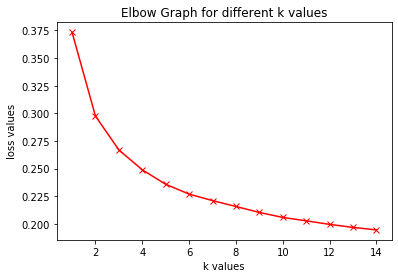

In [10]:
loss_k = list()


k_range = range(1,15)

for k in k_range:  
    temp_model = KMeans(n_clusters=k).fit(rescaled_data)     
      
    loss_k.append(sum(np.min(cdist(rescaled_data, temp_model.cluster_centers_, 
                      'euclidean'),axis=1)) / rescaled_data.shape[0]) 

plt.plot(k_range, loss_k, 'rx-')
plt.title('Elbow Graph for different k values')
plt.xlabel('k values')
plt.ylabel('loss values')

__Here comes a discussion.__

Although the optimal k value resulted from the previous figure is 4 (might also be 3 or 5), the results when I picked k=4 were not satisfactory for me (Some players that I would consider in seperate clusters were in the same cluster). After this obsevation, I decided to set k value as 7, as the number of clusters is a user specified parameter at all.

In [11]:
number_of_clusters = 7

kmeanModel = KMeans(n_clusters = number_of_clusters ) 
kmeanModel.fit(rescaled_data) 

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=7, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

After completing the clustering operation, some identifier attributes (Name and Age) and the cluster labels of players are added so that similar players in each cluster will be observed. 

In [12]:
rescaled_data['Name'] = data_pd_cleaned['Name']
rescaled_data['Age'] = data_pd_cleaned['Age']
rescaled_data['Cluster'] = kmeanModel.labels_

In order to evaluate our model and to see similar players within the same clusters, show_cluster_samples() function is created.

In [13]:
def show_cluster_samples(df, cluster_no, number_of_samples):
    return  df[df['Cluster'] == cluster_no][:number_of_samples]

In [14]:
for cluster_no in range(number_of_clusters):
    display(show_cluster_samples(rescaled_data, cluster_no, 5))

,pace_index,shooting_index,passing_index,dribbling_index,defending_index,physical_index,height,weight,Name,Age,Cluster
3,0.372093,0.683761,0.731959,0.477612,0.338462,0.311321,0.520833,0.330827,K. De Bruyne,27,0
5,0.364341,0.615385,0.701031,0.597015,0.438462,0.226415,0.375,0.270677,L. Modrić,32,0
9,0.271318,0.700855,0.783505,0.492537,0.500000,0.150943,0.583333,0.43609,T. Kroos,28,0
23,0.348837,0.752137,0.783505,0.567164,0.292308,0.216981,0.520833,0.466165,J. Rodríguez,26,0
25,0.372093,0.641026,0.721649,0.656716,0.376923,0.198113,0.416667,0.481203,Isco,26,0


,pace_index,shooting_index,passing_index,dribbling_index,defending_index,physical_index,height,weight,Name,Age,Cluster
10,0.372093,0.367521,0.432990,0.328358,0.753846,0.528302,0.6875,0.466165,D. Godín,32,1
19,0.403101,0.358974,0.360825,0.298507,0.776923,0.556604,0.6875,0.578947,G. Chiellini,33,1
36,0.503876,0.128205,0.247423,0.358209,0.838462,0.660377,0.6875,0.646617,K. Koulibaly,27,1
52,0.550388,0.324786,0.402062,0.298507,0.707692,0.452830,0.729167,0.518797,R. Varane,25,1
63,0.434109,0.324786,0.288660,0.388060,0.761538,0.575472,0.6875,0.729323,M. Benatia,31,1


,pace_index,shooting_index,passing_index,dribbling_index,defending_index,physical_index,height,weight,Name,Age,Cluster
0,0.511628,0.743590,0.773196,0.716418,0.123077,0.160377,0.3125,0.368421,L. Messi,31,2
2,0.558140,0.717949,0.711340,0.716418,0.130769,0.169811,0.416667,0.300752,Neymar Jr,26,2
4,0.550388,0.700855,0.701031,0.701493,0.138462,0.207547,0.375,0.398496,E. Hazard,27,2
11,0.333333,0.683761,0.783505,0.746269,0.284615,0.216981,0.375,0.285714,David Silva,32,2
13,0.503876,0.752137,0.742268,0.656716,0.100000,0.254717,0.479167,0.413534,P. Dybala,24,2


,pace_index,shooting_index,passing_index,dribbling_index,defending_index,physical_index,height,weight,Name,Age,Cluster
1,0.503876,0.752137,0.608247,0.537313,0.153846,0.367925,0.6875,0.548872,Cristiano Ronaldo,33,3
6,0.410853,0.726496,0.608247,0.522388,0.276923,0.386792,0.583333,0.601504,L. Suárez,31,3
8,0.410853,0.769231,0.587629,0.537313,0.207692,0.424528,0.583333,0.496241,R. Lewandowski,29,3
14,0.341085,0.777778,0.618557,0.477612,0.276923,0.424528,0.6875,0.646617,H. Kane,24,3
17,0.387597,0.743590,0.536082,0.417910,0.315385,0.462264,0.625,0.451128,E. Cavani,31,3


,pace_index,shooting_index,passing_index,dribbling_index,defending_index,physical_index,height,weight,Name,Age,Cluster
46,0.596899,0.692308,0.618557,0.537313,0.192308,0.264151,0.583333,0.413534,L. Sané,22,4
104,0.550388,0.709402,0.556701,0.567164,0.230769,0.301887,0.583333,0.43609,A. Martial,22,4
148,0.635659,0.700855,0.484536,0.567164,0.176923,0.339623,0.520833,0.413534,T. Werner,22,4
171,0.558140,0.683761,0.567010,0.507463,0.253846,0.320755,0.583333,0.451128,Rodrigo,27,4
208,0.558140,0.692308,0.701031,0.656716,0.115385,0.273585,0.625,0.56391,J. Brandt,22,4


,pace_index,shooting_index,passing_index,dribbling_index,defending_index,physical_index,height,weight,Name,Age,Cluster
7,0.364341,0.487179,0.505155,0.328358,0.653846,0.452830,0.583333,0.533835,Sergio Ramos,32,5
16,0.170543,0.487179,0.659794,0.492537,0.653846,0.443396,0.6875,0.43609,Sergio Busquets,29,5
22,0.255814,0.547009,0.536082,0.343284,0.638462,0.500000,0.625,0.56391,Casemiro,26,5
29,0.248062,0.487179,0.587629,0.447761,0.723077,0.349057,0.729167,0.699248,M. Hummels,29,5
33,0.364341,0.452991,0.536082,0.358209,0.669231,0.433962,0.583333,0.533835,Thiago Silva,33,5


,pace_index,shooting_index,passing_index,dribbling_index,defending_index,physical_index,height,weight,Name,Age,Cluster
12,0.410853,0.470085,0.474227,0.507463,0.576923,0.424528,0.270833,0.368421,N. Kanté,27,6
111,0.480620,0.307692,0.525773,0.507463,0.615385,0.415094,0.375,0.383459,Carvajal,26,6
119,0.503876,0.478632,0.536082,0.328358,0.553846,0.386792,0.583333,0.330827,K. Walker,28,6
167,0.472868,0.256410,0.463918,0.402985,0.700000,0.509434,0.520833,0.43609,Nacho Fernández,28,6
174,0.395349,0.444444,0.432990,0.477612,0.630769,0.462264,0.416667,0.270677,I. Gueye,28,6


## Comments & Evaluation

In this step, each of 7 clusters will be evaluated in terms of their general characteristics.

### Cluster 0 (classy creator): 
- These players are very important for the playmaking process.
- They represent a transition between defence and attack.
- Characteristics:
    - __very good__ at passing.
- Examples: Kevin De Bruyne, Luka Modric, etc.

In [15]:
show_cluster_samples(rescaled_data, 0, 5)

,pace_index,shooting_index,passing_index,dribbling_index,defending_index,physical_index,height,weight,Name,Age,Cluster
3,0.372093,0.683761,0.731959,0.477612,0.338462,0.311321,0.520833,0.330827,K. De Bruyne,27,0
5,0.364341,0.615385,0.701031,0.597015,0.438462,0.226415,0.375,0.270677,L. Modrić,32,0
9,0.271318,0.700855,0.783505,0.492537,0.500000,0.150943,0.583333,0.43609,T. Kroos,28,0
23,0.348837,0.752137,0.783505,0.567164,0.292308,0.216981,0.520833,0.466165,J. Rodríguez,26,0
25,0.372093,0.641026,0.721649,0.656716,0.376923,0.198113,0.416667,0.481203,Isco,26,0


### Cluster 1 (genuine defender): 
- This cluster consists of the solid defender players(most of the time centre-backs).
- They are mostly not responsible for playmaking. Their genuine duty is to stop opponent attackers by tackling etc.
- Characteristics: 
    - __very good__ defending and physical stats.
    - most of the time, tall players.
- Examples: Diego Godin, Chiellini, Koulibaly, etc.

In [16]:
show_cluster_samples(rescaled_data, 1, 5)

,pace_index,shooting_index,passing_index,dribbling_index,defending_index,physical_index,height,weight,Name,Age,Cluster
10,0.372093,0.367521,0.432990,0.328358,0.753846,0.528302,0.6875,0.466165,D. Godín,32,1
19,0.403101,0.358974,0.360825,0.298507,0.776923,0.556604,0.6875,0.578947,G. Chiellini,33,1
36,0.503876,0.128205,0.247423,0.358209,0.838462,0.660377,0.6875,0.646617,K. Koulibaly,27,1
52,0.550388,0.324786,0.402062,0.298507,0.707692,0.452830,0.729167,0.518797,R. Varane,25,1
63,0.434109,0.324786,0.288660,0.388060,0.761538,0.575472,0.6875,0.729323,M. Benatia,31,1


### Cluster 2 (zig-zag dribbler): 
- This kind of players are quite effective in dribbling inside the penalty area.
- They are not famous for very fast sprints, but they are more comfortable with zig-zag dribblings.
- Characteristics:
    - low physical power.
    - __very good__ at dribbling and shooting.
- Examples: Lionel Messi, Neymar, Eden Hazard, etc. 

In [17]:
show_cluster_samples(rescaled_data, 2, 5)

,pace_index,shooting_index,passing_index,dribbling_index,defending_index,physical_index,height,weight,Name,Age,Cluster
0,0.511628,0.743590,0.773196,0.716418,0.123077,0.160377,0.3125,0.368421,L. Messi,31,2
2,0.558140,0.717949,0.711340,0.716418,0.130769,0.169811,0.416667,0.300752,Neymar Jr,26,2
4,0.550388,0.700855,0.701031,0.701493,0.138462,0.207547,0.375,0.398496,E. Hazard,27,2
11,0.333333,0.683761,0.783505,0.746269,0.284615,0.216981,0.375,0.285714,David Silva,32,2
13,0.503876,0.752137,0.742268,0.656716,0.100000,0.254717,0.479167,0.413534,P. Dybala,24,2


### Cluster 3 (solid scorer): 
- These players are considered as the main goal change for their teams.
- They are not famous for very fast sprints, but they are more comfortable with zig-zag dribblings.
- Characteristics:
    - __very good__ shooting skills.
    - good physical stats.
- Examples: C. Ronaldo, Luis Suarez, etc.

In [18]:
show_cluster_samples(rescaled_data, 3, 5)

,pace_index,shooting_index,passing_index,dribbling_index,defending_index,physical_index,height,weight,Name,Age,Cluster
1,0.503876,0.752137,0.608247,0.537313,0.153846,0.367925,0.6875,0.548872,Cristiano Ronaldo,33,3
6,0.410853,0.726496,0.608247,0.522388,0.276923,0.386792,0.583333,0.601504,L. Suárez,31,3
8,0.410853,0.769231,0.587629,0.537313,0.207692,0.424528,0.583333,0.496241,R. Lewandowski,29,3
14,0.341085,0.777778,0.618557,0.477612,0.276923,0.424528,0.6875,0.646617,H. Kane,24,3
17,0.387597,0.743590,0.536082,0.417910,0.315385,0.462264,0.625,0.451128,E. Cavani,31,3


### Cluster 4 (cheetah scorer): 
- This kind of players are quite effective in the empty space.
- They are famous for their very fast sprints. 
- Characteristics:
    - low physical power.
    - quite fast players.
    - __very good__ at dribbling and shooting.
- Examples: Leroy Sane, Anthony Martial, etc.

In [19]:
show_cluster_samples(rescaled_data, 4, 5)

,pace_index,shooting_index,passing_index,dribbling_index,defending_index,physical_index,height,weight,Name,Age,Cluster
46,0.596899,0.692308,0.618557,0.537313,0.192308,0.264151,0.583333,0.413534,L. Sané,22,4
104,0.550388,0.709402,0.556701,0.567164,0.230769,0.301887,0.583333,0.43609,A. Martial,22,4
148,0.635659,0.700855,0.484536,0.567164,0.176923,0.339623,0.520833,0.413534,T. Werner,22,4
171,0.558140,0.683761,0.567010,0.507463,0.253846,0.320755,0.583333,0.451128,Rodrigo,27,4
208,0.558140,0.692308,0.701031,0.656716,0.115385,0.273585,0.625,0.56391,J. Brandt,22,4


### Cluster 5 (playmaker defender): 
- This cluster consists of defenders (mostly centre-back and rarely defensive midfielder).
- They are good at passing and shooting. This makes them special as this kind of players are responsible for playmaking (i.e. starting point of the attack organizations.) 
- Characteristics:
    - good defending skills (not surprising).
    - __good__ at passing and shooting.
- Examples: Sergio Ramos, Sergio Busquets, etc.

In [20]:
show_cluster_samples(rescaled_data, 5, 5)

,pace_index,shooting_index,passing_index,dribbling_index,defending_index,physical_index,height,weight,Name,Age,Cluster
7,0.364341,0.487179,0.505155,0.328358,0.653846,0.452830,0.583333,0.533835,Sergio Ramos,32,5
16,0.170543,0.487179,0.659794,0.492537,0.653846,0.443396,0.6875,0.43609,Sergio Busquets,29,5
22,0.255814,0.547009,0.536082,0.343284,0.638462,0.500000,0.625,0.56391,Casemiro,26,5
29,0.248062,0.487179,0.587629,0.447761,0.723077,0.349057,0.729167,0.699248,M. Hummels,29,5
33,0.364341,0.452991,0.536082,0.358209,0.669231,0.433962,0.583333,0.533835,Thiago Silva,33,5


### Cluster 6 (fast defender): 
- Defenders with high velocity.
- Not a very good seperated cluster. It is a combination of left/right back players and speedy defensive midfielder.
- Characteristics: high speed, good physical stats.
- Examples: N. Kante, Carvajal, etc. 

In [21]:
show_cluster_samples(rescaled_data, 6, 5)

,pace_index,shooting_index,passing_index,dribbling_index,defending_index,physical_index,height,weight,Name,Age,Cluster
12,0.410853,0.470085,0.474227,0.507463,0.576923,0.424528,0.270833,0.368421,N. Kanté,27,6
111,0.480620,0.307692,0.525773,0.507463,0.615385,0.415094,0.375,0.383459,Carvajal,26,6
119,0.503876,0.478632,0.536082,0.328358,0.553846,0.386792,0.583333,0.330827,K. Walker,28,6
167,0.472868,0.256410,0.463918,0.402985,0.700000,0.509434,0.520833,0.43609,Nacho Fernández,28,6
174,0.395349,0.444444,0.432990,0.477612,0.630769,0.462264,0.416667,0.270677,I. Gueye,28,6


## Average Statistics for Each Cluster

In [25]:
rescaled_data_mean_stats = pd.DataFrame()
nicknames = ['classy creator', 'genuine defender', 'zig-zag dribbler', 
             'solid scorer', 'cheetah scorer', 'playmaker defender', 'fast defender']

In [26]:
for cl_no in range(number_of_clusters):
    rescaled_data_mean_stats[nicknames[cl_no]] = rescaled_data[rescaled_data['Cluster']==cl_no].describe().loc['mean',:]

In [27]:
rescaled_data_mean_stats

,classy creator,genuine defender,zig-zag dribbler,solid scorer,cheetah scorer,playmaker defender,fast defender
pace_index,0.448213,0.463795,0.590973,0.485594,0.661553,0.348435,0.558428
shooting_index,0.554772,0.299422,0.626710,0.721341,0.642832,0.492038,0.379789
passing_index,0.594734,0.326003,0.620349,0.472672,0.469652,0.533178,0.443553
dribbling_index,0.463451,0.331158,0.620445,0.476189,0.550523,0.369799,0.440528
defending_index,0.452348,0.707274,0.229531,0.237052,0.190461,0.593589,0.541818
physical_index,0.355930,0.635784,0.253391,0.494208,0.379775,0.488871,0.458081
Age,25.816423,24.859334,24.188470,26.267072,23.022693,27.684424,23.625802
Cluster,0.000000,1.000000,2.000000,3.000000,4.000000,5.000000,6.000000


## Some Final Observations

- Young defenders appear in the clusters _fast defender_ and _genuine defender_. As they get older, they tend to improve their playmaking skills.

- _cheetah scorers_ are more likely the young wing-forwards while _solid scorers_ are more experienced players. 

- _zig-zag dribblers_ have very low physical stats such as aggression, jumping, stamina, strength. Although it looks like a disadvantage, this characteristic probably lets them show their dribbling skills in a better way.

- Players with the best physical stats are in the cluster _genuine defender_.


Emre Dogan  
Completed on January 19, 2020.
